In [1]:
import matplotlib.pyplot as plt

import pyBeamSim
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data.csv', index_col=0)
df

,drift1_len,quad1_len,quad1_gra,drift2_len,quad2_len,quad2_gra,x_avg0,x_avg1,x_avg2,x_avg3
0,0.171976,0.227219,6.871036,0.454229,0.365654,3.684258,-2.582750e-09,0.000019,-7.516533e-07,-0.000006
1,0.238632,0.307858,14.284877,0.131167,0.148784,-11.128181,-8.567334e-08,0.000027,8.242973e-08,-0.000018
2,0.370813,0.366528,-0.739557,0.416881,0.230250,-6.940373,-7.746737e-08,0.000038,-8.708650e-07,-0.000065
3,0.358177,0.261144,14.257542,0.164811,0.189567,-18.844069,-1.373889e-07,0.000028,-1.105493e-07,0.000013
4,0.227867,0.252248,-4.161450,0.418909,0.483086,5.168512,-1.443633e-07,0.000026,1.735573e-06,0.000078
...,...,...,...,...,...,...,...,...,...,...
995,0.207924,0.274640,-5.343225,0.373862,0.399816,-13.465834,-8.671265e-07,0.000024,2.055004e-06,0.000089
996,0.294963,0.479572,19.643351,0.488004,0.324490,-0.348803,-3.036436e-07,0.000029,-2.515315e-06,-0.000159
997,0.381755,0.355085,-19.126991,0.321795,0.341872,-7.674232,-1.342506e-06,0.000035,-1.211038e-06,-0.000378
998,0.168492,0.138093,14.371468,0.198199,0.151332,-7.951185,-1.583674e-06,0.000019,1.502606e-06,0.000008


In [3]:
# last 4 columns as y_true
X = df.iloc[:, :-4]
y = df.iloc[:, -4:]
# transform df into tensor
X = torch.Tensor(X.values).unsqueeze(2) # add a dim: input_size
y = torch.Tensor(y.values)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

In [4]:
print(f'y_train.shape: {y_train.shape}')
print(f'X_train.shape: {X_train.shape}')

y_train.shape: torch.Size([800, 4])
X_train.shape: torch.Size([800, 6, 1])


In [5]:
from torch.utils.data import TensorDataset, DataLoader
batch_size = 8

# generate dataset and dataloader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

In [6]:
import torch.optim as optim
from model import Model, Model2

In [14]:
"""
taker MLP(7, 7) as encoder, model2 as decoder, the last output as loss
"""
def get_encoder():
        return nn.Sequential(nn.Linear(6, 64),
                        nn.Dropout(0.1),
                        nn.ReLU(),
                        nn.Linear(64, 128),
                        nn.Dropout(0.1),
                        nn.ReLU(),
                        nn.Linear(128, 32),
                        nn.Dropout(0.1),
                        nn.ReLU(),
                        nn.Linear(32, 7),
                        )    # result param should positive  #nn.ReLU()

In [15]:
from model import Model2
decoder = Model2(1, 30, 1, 4)
decoder.load_state_dict(torch.load('model_save/LSTM2.pth'))
# restore model


<All keys matched successfully>

In [16]:
X[0, :, :].shape

torch.Size([6, 1])

In [17]:
a = [X[0, :, :], X[1, :, :], X[2, :, :]]
b = [y[0, :], y[1, :], y[2, :]]

print(f'x1.shape: {a[0].shape}')
print(f'y1.shape: {b[0].shape}')


IndexError: too many indices for tensor of dimension 1

In [18]:
# # encoder first, get the best 7 params
# output_encoder = encoder(X.squeeze(2))      # random input
# print(f'output_encoder.shape: {output_encoder.shape}')
# 
# # decoder then, get loss(the last avg_x)
# output_decoder = decoder(output_encoder.unsqueeze(2), y[:, :1])
# print(f'output_decoder.shape: {output_decoder.shape}')
# 
# # freeze the params of decoder
# for param in decoder.parameters():
#     param.requires_grad = False
# # take the last avg_x as loss
# last_avg = output_decoder[:, -1]
# print(f'last_avg.shape:     {last_avg.shape}')
# 
# # cal the loss

In [19]:
results = []
para1s = []
para2s = []
for i, (x, y) in enumerate(zip(a, b)):
    param1 = []
    param2 = []
    avg = []
    encoder = get_encoder()
    optimizer = optim.Adam(encoder.parameters(), lr=0.001)
    for j in range(1000):
        # encoder first, get the best 7 params , everytime should be a new encoder??
        output_encoder = encoder(x.squeeze(1))      # random input
        # print(f' output_encoder.shape: {output_encoder.shape}')   torch.Size([7])
        
        # decoder then, get loss(the last avg_x)
        output_decoder = decoder(output_encoder.view(1, -1, 1), y[0].view(1, -1))  # decoder input: x 3-D, y 2-D for batch
        # print(f' output_decoder.shape: {output_decoder.shape}')   torch.Size([1, 3])
        
        # freeze the params of decoder
        for param in decoder.parameters():
            param.requires_grad = False
        # take the last avg_x as loss
        loss = output_decoder[:, -1]
        avg.append(loss.detach())
        # print(f' loss.shape:     {last_avg.shape}')        torch.Size([1])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print(j)
        # every epoch, record the param vary
        param1.append(encoder(x.squeeze(1)).detach()[0])
        param2.append(encoder(x.squeeze(1)).detach()[1])
        
    result_i = encoder(x.squeeze(1))
    results.append(result_i)
    para1s.append(param1)
    para2s.append(param2)

In [20]:
results[0]

tensor([ 88.0281, 220.8211, 241.8145, 227.9180, 294.3734, 315.8092, 210.4049],
       grad_fn=<AddBackward0>)

In [21]:
results[1]

tensor([127.1973, 263.1410, 249.4067, 253.6364, 277.4142, 309.1535, 207.2808],
       grad_fn=<AddBackward0>)

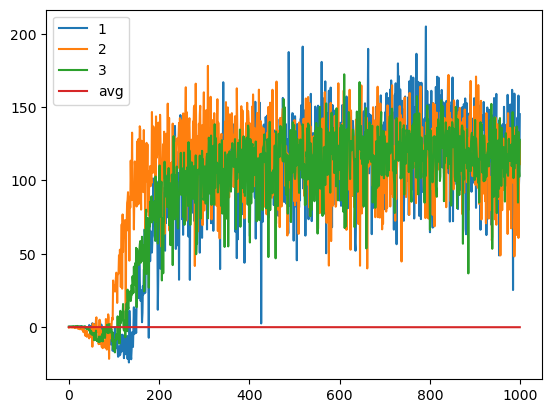

In [22]:
plt.plot(para1s[0], label='1')
plt.plot(para1s[1], label='2')
plt.plot(para1s[2], label='3')
plt.plot(avg, label='avg')
plt.legend()

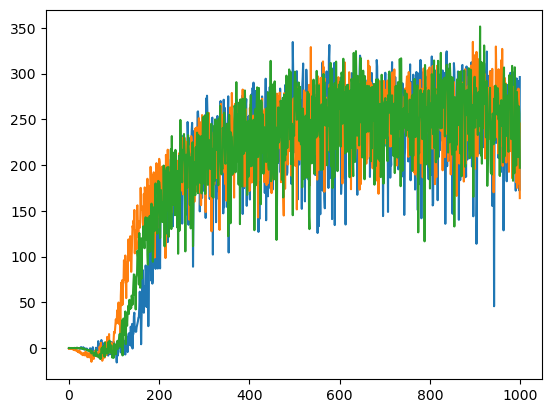

In [23]:
plt.plot(para2s[0])
plt.plot(para2s[1])
plt.plot(para2s[2])

In [13]:
avg[:3]

[]